In [55]:
import os

# List all files in the df_scaledset folder
dataset_path = "/kaggle/input/"
os.listdir(dataset_path)


['nasdq-dataset', 'nasdaq-sentiments', 'sentiments']

# NASDAQ Market Analysis & Forecasting

**Author:** Ibrahim Yahaya  
**Last updated:** July 2025

---

## Project Overview

This notebook analyzes and forecasts NASDAQ prices using market data and news sentiment.  
It demonstrates data merging, feature engineering, exploratory analysis, and deep learning models (LSTM, GRU, Bi-LSTM, Attention).

---

## Requirements

- Python 3.8+
- pandas, numpy, matplotlib, seaborn
- scikit-learn
- tensorflow/keras
- statsmodels

Install with:

```
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow statsmodels
```

In [56]:
# Reproducibility
import numpy as np
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## 1. Data Loading

Load NASDAQ price data and news sentiment data.

In [57]:
import os
import pandas as pd

# List all files in the dataset folder
dataset_path = "/kaggle/input/"
print(os.listdir(dataset_path))
print(os.listdir("/kaggle/input/nasdq-dataset"))

# Load datasets
file_path = "/kaggle/input/nasdaq-sentiments/news_sentiment.csv"
file_path1 = "/kaggle/input/nasdq-dataset/nasdq.csv"

sentim_df = pd.read_csv(file_path)
nasdaq_df = pd.read_csv(file_path1)

print(nasdaq_df.head())
print(sentim_df.head())

['nasdq-dataset', 'nasdaq-sentiments', 'sentiments']
['nasdq.csv']
         Date      Open      High       Low     Close     Volume  \
0  2010-01-04  6.640000  6.810000  6.633333  6.746667  6514500.0   
1  2010-01-05  6.643333  6.773333  6.643333  6.766667  4445100.0   
2  2010-01-06  6.733333  6.786667  6.720000  6.763333  7340100.0   
3  2010-01-07  6.750000  6.766667  6.630000  6.673333  8498400.0   
4  2010-01-08  6.676667  6.766667  6.626667  6.743333  4347600.0   

   InterestRate  ExchangeRate    VIX  TEDSpread  EFFR         Gold        Oil  
0          0.11        1.4419  20.04       0.17  0.12  1117.699951  81.510002  
1          0.11        1.4402  19.35       0.18  0.12  1118.099976  81.769997  
2          0.11        1.4404  19.16       0.19  0.12  1135.900024  83.180000  
3          0.11        1.4314  19.06       0.20  0.10  1133.099976  82.660004  
4          0.11        1.4357  18.13       0.20  0.11  1138.199951  82.750000  
         date  compound  positive  negative 

## 2. Data Preprocessing & Feature Engineering

In [58]:
# Convert date columns to datetime
nasdaq_df['Date'] = pd.to_datetime(nasdaq_df['Date'])
sentim_df['date'] = pd.to_datetime(sentim_df['date'])
sentim_df.rename(columns={'date': 'Date'}, inplace=True)

# Filter by intersection date range
start_date = '2010-01-04'
end_date = '2023-10-23'
nasdaq_df = nasdaq_df[(nasdaq_df['Date'] >= start_date) & (nasdaq_df['Date'] <= end_date)]
sentim_df = sentim_df[(sentim_df['Date'] >= start_date) & (sentim_df['Date'] <= end_date)]

# Merge and sort
merged_df = nasdaq_df.merge(sentim_df, on='Date', how='left').sort_values('Date')
df = merged_df.drop(columns=['positive', 'negative', 'neutral'], axis='columns')

# Fill missing sentiment with forward fill (neutral effect)
df[['compound']] = df[['compound']].fillna(method='ffill')

# Remove duplicates and drop NA
df = df.drop_duplicates()
df = df.dropna()

print(df.head())

        Date      Open      High       Low     Close     Volume  InterestRate  \
0 2010-01-04  6.640000  6.810000  6.633333  6.746667  6514500.0          0.11   
1 2010-01-05  6.643333  6.773333  6.643333  6.766667  4445100.0          0.11   
2 2010-01-06  6.733333  6.786667  6.720000  6.763333  7340100.0          0.11   
3 2010-01-07  6.750000  6.766667  6.630000  6.673333  8498400.0          0.11   
4 2010-01-08  6.676667  6.766667  6.626667  6.743333  4347600.0          0.11   

   ExchangeRate    VIX  TEDSpread  EFFR         Gold        Oil  compound  
0        1.4419  20.04       0.17  0.12  1117.699951  81.510002  0.389463  
1        1.4402  19.35       0.18  0.12  1118.099976  81.769997  0.275734  
2        1.4404  19.16       0.19  0.12  1135.900024  83.180000 -0.083962  
3        1.4314  19.06       0.20  0.10  1133.099976  82.660004  0.118636  
4        1.4357  18.13       0.20  0.11  1138.199951  82.750000  0.150677  


<ipython-input-58-142d2c619496>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['compound']] = df[['compound']].fillna(method='ffill')


In [59]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'InterestRate',
       'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil', 'compound'],
      dtype='object')

In [60]:
print(len(df))

3648


In [7]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
InterestRate    0
ExchangeRate    0
VIX             0
TEDSpread       0
EFFR            0
Gold            0
Oil             0
compound        0
dtype: int64

## 3. Exploratory Data Analysis

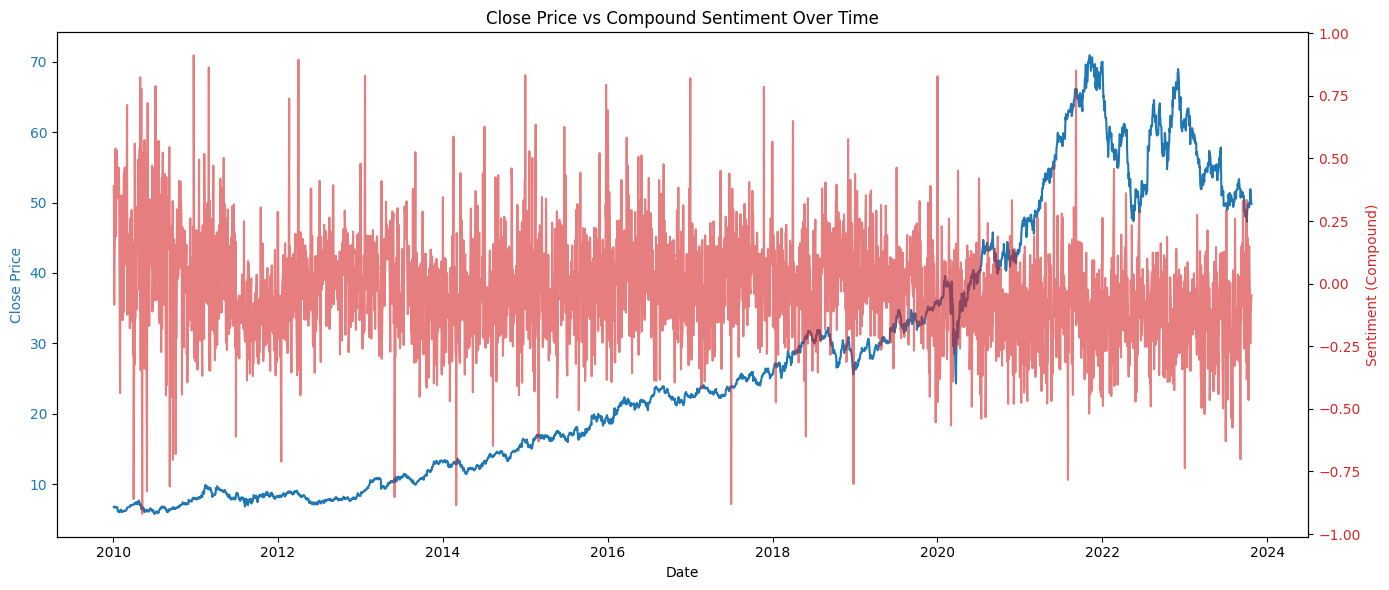

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


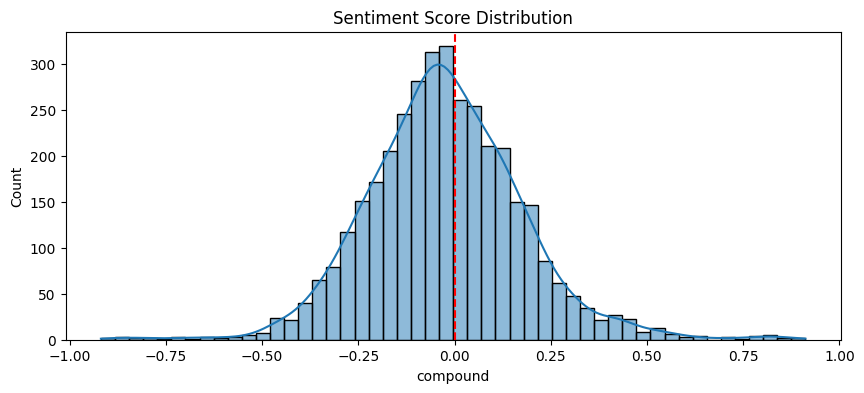

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Close Price vs Compound Sentiment
fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(df['Date'], df['Close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sentiment (Compound)', color=color)
ax2.plot(df['Date'], df['compound'], color=color, alpha=0.6, label='Compound Sentiment')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Close Price vs Compound Sentiment Over Time')
fig.tight_layout()
plt.show()

# Sentiment Score Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['compound'], bins=50, kde=True)
plt.title('Sentiment Score Distribution')
plt.axvline(0, color='r', linestyle='--', label='Neutral')
plt.show()

In [62]:
# Lagged sentiment features and correlation
df['Lagged_Compound_1'] = df['compound'].shift(1)
df['Lagged_Compound_2'] = df['compound'].shift(2)
df['Lagged_Compound_3'] = df['compound'].shift(3)

correlation = df[['compound', 'Close']].corr().iloc[0, 1]
correlation1 = df[['Lagged_Compound_1', 'Close']].corr().iloc[0, 1]
correlation2 = df[['Lagged_Compound_2', 'Close']].corr().iloc[0, 1]
correlation3 = df[['Lagged_Compound_3', 'Close']].corr().iloc[0, 1]

print(f"Correlation between sentiment and price: {correlation:.4f}")
print(f"Correlation between lagged_1 sentiment and price: {correlation1:.4f}")
print(f"Correlation between lagged_2 sentiment and price: {correlation2:.4f}")
print(f"Correlation between lagged_3 sentiment and price: {correlation3:.4f}")

Correlation between sentiment and price: -0.2551
Correlation between lagged_1 sentiment and price: -0.2554
Correlation between lagged_2 sentiment and price: -0.2555
Correlation between lagged_3 sentiment and price: -0.2553


# 30-DAY ROLLING CORRELATION

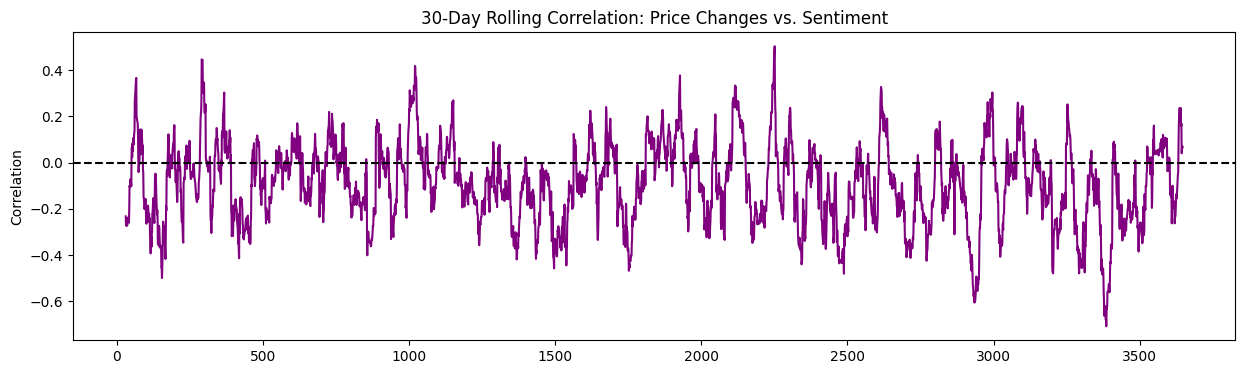

In [63]:
df['Price_Change'] = df['Close'].pct_change()
rolling_corr = df['Price_Change'].rolling(30).corr(df['compound'])

plt.figure(figsize=(15, 4))
rolling_corr.plot(color='purple')
plt.axhline(0, color='k', linestyle='--')
plt.title('30-Day Rolling Correlation: Price Changes vs. Sentiment')
plt.ylabel('Correlation')
plt.show()

Sentiment isn’t a dominant driver, but it does influence the market sometimes


In [64]:
# Feature engineering: technical indicators
df['Log_Return'] = np.log(1 + df['Price_Change'])
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['BB_Mid'] = df['Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Mid'] + 2 * df['Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Mid'] - 2 * df['Close'].rolling(window=20).std()
obv = [0]
for i in range(1, len(df)):
    if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
        obv.append(obv[-1] + df['Volume'].iloc[i])
    elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
        obv.append(obv[-1] - df['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df['OBV'] = obv
df = df.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [65]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'InterestRate',
       'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil', 'compound',
       'Lagged_Compound_1', 'Lagged_Compound_2', 'Lagged_Compound_3',
       'Price_Change', 'Log_Return', 'SMA_20', 'EMA_20', 'RSI', 'MACD',
       'MACD_Signal', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'OBV'],
      dtype='object')

In [66]:
print(df.isnull().sum())

Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
InterestRate         0
ExchangeRate         0
VIX                  0
TEDSpread            0
EFFR                 0
Gold                 0
Oil                  0
compound             0
Lagged_Compound_1    0
Lagged_Compound_2    0
Lagged_Compound_3    0
Price_Change         0
Log_Return           0
SMA_20               0
EMA_20               0
RSI                  0
MACD                 0
MACD_Signal          0
BB_Mid               0
BB_Upper             0
BB_Lower             0
OBV                  0
dtype: int64


In [67]:
df

,Date,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,...,Log_Return,SMA_20,EMA_20,RSI,MACD,MACD_Signal,BB_Mid,BB_Upper,BB_Lower,OBV
19,2010-01-29,6.090000,6.156667,5.996667,5.996667,9038700.0,0.11,1.3870,24.62,0.17,...,-0.013801,6.506333,6.406771,16.811666,-0.183315,-0.117107,6.506333,7.116197,5.896469,-41460300.0
20,2010-02-01,6.050000,6.200000,6.016667,6.140000,12008700.0,0.13,1.3904,22.59,0.15,...,0.023621,6.476000,6.381364,28.611936,-0.181047,-0.129895,6.476000,7.095800,5.856200,-29451600.0
21,2010-02-02,6.153333,6.240000,6.133333,6.193333,5548800.0,0.13,1.3955,21.48,0.15,...,0.008649,6.447333,6.363457,27.999995,-0.172951,-0.138507,6.447333,7.063553,5.831114,-23902800.0
22,2010-02-03,6.413333,6.423333,6.240000,6.353333,18415500.0,0.13,1.3907,21.60,0.15,...,0.025506,6.426833,6.362492,34.545453,-0.151874,-0.141180,6.426833,7.025828,5.827838,-5487300.0
23,2010-02-04,6.310000,6.310000,6.110000,6.120000,11436000.0,0.13,1.3759,26.08,0.16,...,-0.037417,6.399167,6.339398,29.820638,-0.152244,-0.143393,6.399167,7.001330,5.797003,-16923300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2023-10-17,50.299999,50.709999,49.869999,49.930000,3687200.0,5.33,1.0593,17.88,0.09,...,-0.007383,48.991000,49.567956,58.158344,-0.154346,-0.378525,48.991000,50.473088,47.508912,636979400.0
3644,2023-10-18,51.290001,53.299999,50.869999,51.919998,6685800.0,5.33,1.0532,19.22,0.09,...,0.039082,49.145000,49.791960,71.210193,0.047993,-0.293221,49.145000,51.119345,47.170654,643665200.0
3645,2023-10-19,52.020000,52.040001,51.279999,51.290001,2924100.0,5.33,1.0570,21.40,0.09,...,-0.012208,49.276000,49.934631,65.919831,0.155718,-0.203433,49.276000,51.454743,47.097257,640741100.0
3646,2023-10-20,51.299999,51.540001,50.389999,50.599998,2797100.0,5.33,1.0592,21.71,0.09,...,-0.013544,49.374000,49.997999,62.111123,0.183300,-0.126087,49.374000,51.607914,47.140085,637944000.0


# SUMMARY STATISTICS

In [15]:
from statsmodels.tsa.stattools import adfuller
adfuller(df['Close']) 


(-0.606768531627317,
 0.8694452695563684,
 29,
 3599,
 {'1%': -3.4321682745778963,
  '5%': -2.86234341192807,
  '10%': -2.56719766893431},
 5120.203233506369)

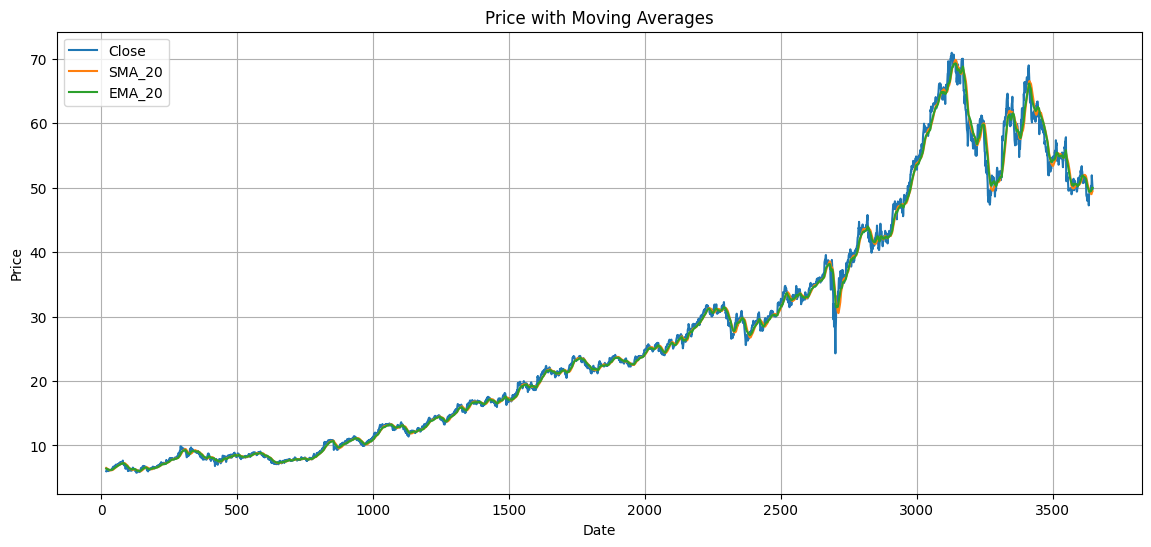

In [68]:
import matplotlib.pyplot as plt

df[['Close', 'SMA_20', 'EMA_20']].plot(figsize=(14,6))
plt.title('Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
print(df.columns)

Index(['Date', 'Close', 'Volume', 'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR',
       'Gold', 'Oil', 'compound', 'Lagged_Compound_1', 'Price_Change',
       'Log_Return', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal',
       'BB_Mid', 'BB_Upper', 'BB_Lower', 'OBV'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Correlation Heatmap')

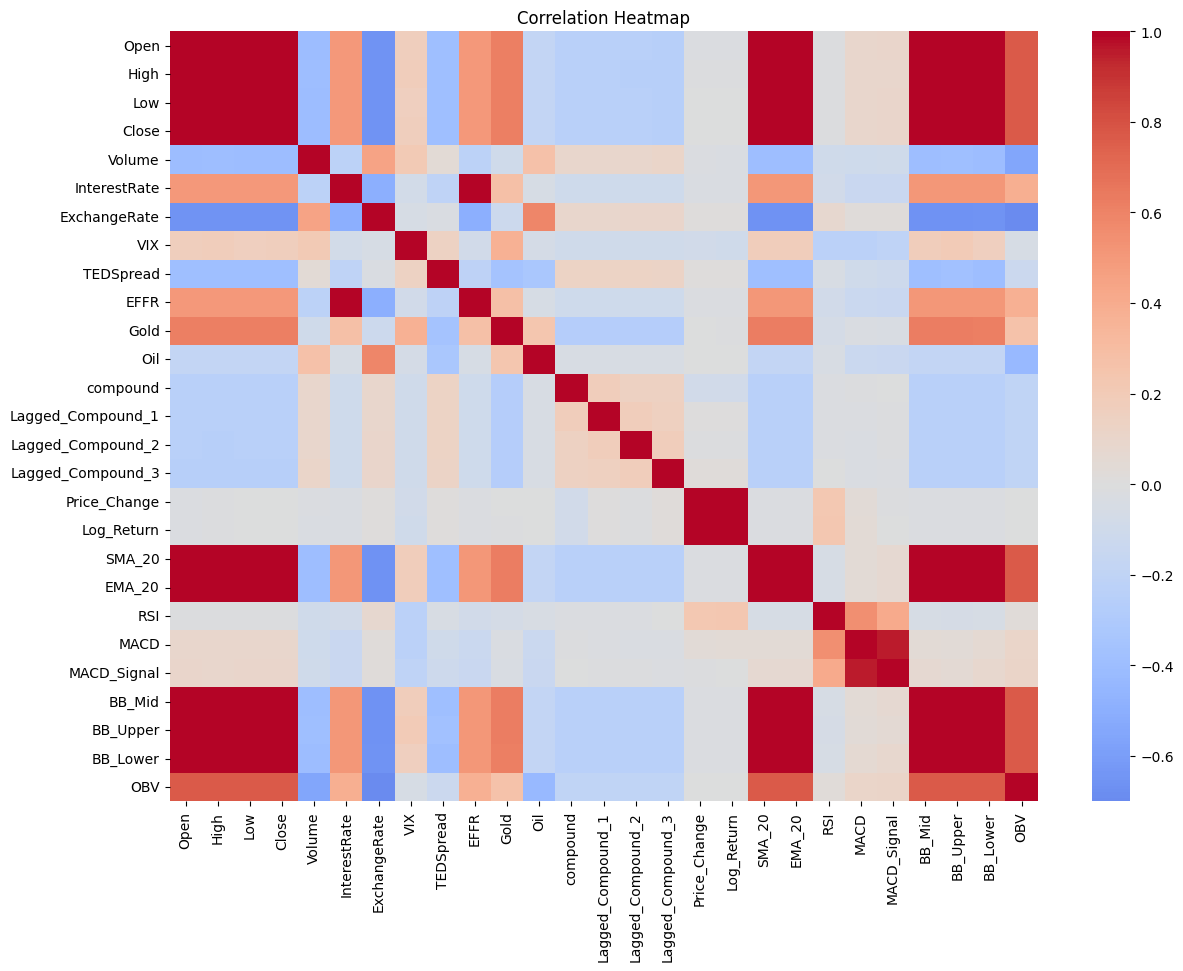

In [69]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(14,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')


## 4. Modeling

In [70]:
# Prepare features and target
df = df.drop(columns=['Open', 'High', 'Low','InterestRate','Lagged_Compound_2','Lagged_Compound_3','EMA_20','BB_Mid'], axis='columns')
# Remove 'Date' from features if present
features = df.drop(['Close'], axis=1)
if 'Date' in features.columns:
    features = features.drop(columns=['Date'])
target = df['Close']



In [71]:
features

,Volume,ExchangeRate,VIX,TEDSpread,EFFR,Gold,Oil,compound,Lagged_Compound_1,Price_Change,Log_Return,SMA_20,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,OBV
19,9038700.0,1.3870,24.62,0.17,0.12,1083.000000,72.889999,0.084589,0.333579,-0.013706,-0.013801,6.506333,16.811666,-0.183315,-0.117107,7.116197,5.896469,-41460300.0
20,12008700.0,1.3904,22.59,0.15,0.14,1104.300049,74.430000,-0.437048,0.084589,0.023902,0.023621,6.476000,28.611936,-0.181047,-0.129895,7.095800,5.856200,-29451600.0
21,5548800.0,1.3955,21.48,0.15,0.14,1117.400024,77.230003,0.044769,-0.437048,0.008686,0.008649,6.447333,27.999995,-0.172951,-0.138507,7.063553,5.831114,-23902800.0
22,18415500.0,1.3907,21.60,0.15,0.13,1111.400024,76.980003,0.241744,0.044769,0.025834,0.025506,6.426833,34.545453,-0.151874,-0.141180,7.025828,5.827838,-5487300.0
23,11436000.0,1.3759,26.08,0.16,0.14,1062.400024,73.139999,0.293232,0.241744,-0.036726,-0.037417,6.399167,29.820638,-0.152244,-0.143393,7.001330,5.797003,-16923300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,3687200.0,1.0593,17.88,0.09,5.33,1922.699951,86.660004,-0.078960,-0.047032,-0.007356,-0.007383,48.991000,58.158344,-0.154346,-0.378525,50.473088,47.508912,636979400.0
3644,6685800.0,1.0532,19.22,0.09,5.33,1955.300049,88.320000,-0.238275,-0.078960,0.039856,0.039082,49.145000,71.210193,0.047993,-0.293221,51.119345,47.170654,643665200.0
3645,2924100.0,1.0570,21.40,0.09,5.33,1968.400024,89.370003,-0.105498,-0.238275,-0.012134,-0.012208,49.276000,65.919831,0.155718,-0.203433,51.454743,47.097257,640741100.0
3646,2797100.0,1.0592,21.71,0.09,5.33,1982.500000,88.750000,-0.105498,-0.105498,-0.013453,-0.013544,49.374000,62.111123,0.183300,-0.126087,51.607914,47.140085,637944000.0


In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target.values.reshape(-1,1))
import pandas as pd
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=df.index)
scaled_df['Close'] = scaled_target

# Sequence creation for LSTM/GRU
def create_sequences(scaled_features, scaled_target, seq_length):
    X, y = [], []
    for i in range(seq_length, len(scaled_features)):
        X.append(scaled_features[i-seq_length:i])
        y.append(scaled_target[i])
    return np.array(X), np.array(y)
sequence_length = 40
X_seq, y_seq = create_sequences(scaled_features, scaled_target, sequence_length)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [79]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (2871, 40, 18)
X_test: (718, 40, 18)
y_train: (2871, 1)
y_test: (718, 1)


In [80]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0126 - mae: 0.0773 - val_loss: 0.0172 - val_mae: 0.1227 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0090 - val_mae: 0.0887 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 8.7466e-04 - mae: 0.0225 - val_loss: 0.0055 - val_mae: 0.0681 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.6164e-04 - mae: 0.0200 - val_loss: 0.0039 - val_mae: 0.0568 - learning_rate: 0.0010
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.9168e-04 - mae: 0.0181 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.4101e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.4059e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0302 - learning_rate: 0.0010
Epoc

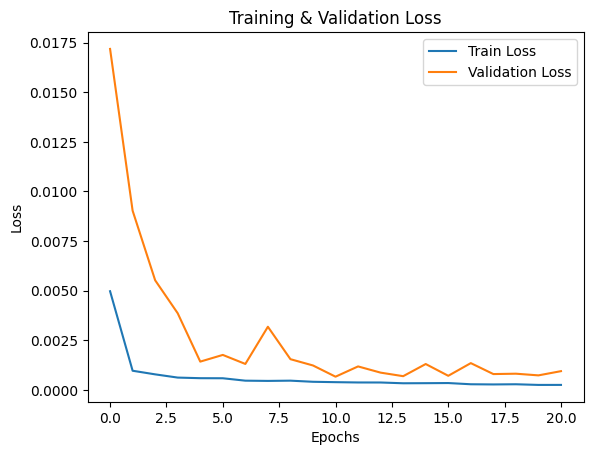

In [81]:
# Plot training history
def plot_loss(history, title='Training & Validation Loss'):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

plot_loss(history)

In [96]:
# Predict and evaluate LSTM
y_pred = model.predict(X_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 7.4867
MAE: 2.2877
R² Score: 0.8050


<ipython-input-95-5e39b81bd235>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
<ipython-input-95-5e39b81bd235>:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
<ipython-input-95-5e39b81bd235>:23: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


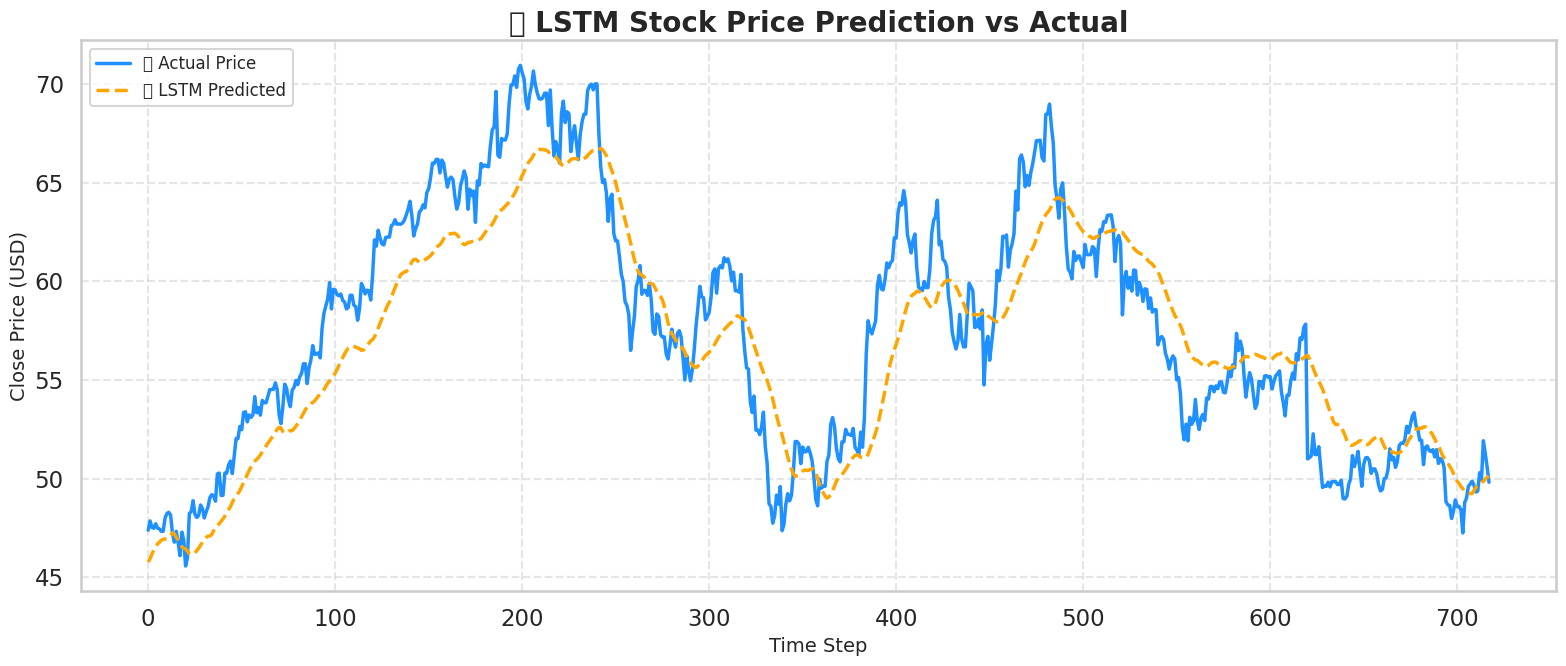

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a modern seaborn theme
sns.set(style="whitegrid", context="talk", palette="muted")

plt.figure(figsize=(16, 7))

# Plot actual vs predicted
plt.plot(y_test_actual, label='📈 Actual Price', linewidth=2.5, color='dodgerblue')
plt.plot(y_pred_actual, label='🤖 LSTM Predicted', linewidth=2.5, linestyle='--', color='orange')

# Title and labels with extra styling
plt.title('📊 LSTM Stock Price Prediction vs Actual', fontsize=20, weight='bold')
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)

# Add legend outside the plot
plt.legend(loc='upper left', frameon=True, fontsize=12)

# Add a slight grid and tight layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Optional: dark background
# plt.style.use('dark_background')

plt.show()


In [84]:

model.save('lstm_model.h5')
print("Model saved successfully.")


Model saved successfully.


## 6. Conclusion

- Sentiment has a mild but non-negligible effect on NASDAQ price movements.
- LSTM model provides reasonable predictive power, but further feature engineering and hyperparameter tuning could improve results.
- Future work: try more advanced architectures, add more macroeconomic and technical features, or use more granular sentiment data.